[albumentations](https://github.com/albu/albumentations)

In [197]:
# !pip3.6 install albumentations

In [1]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.1.6


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


In [5]:
from tensorflow.keras.layers import *
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.applications import xception,InceptionV3#change the architecture
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Nadam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,TensorBoard,EarlyStopping
import tensorflow as tf
import numpy as np
import os
# import Callback

"""config the model input dim, number of labels to classify, batch size to be processed"""

img_width,img_height = 299,299

classes = 2

batch_size = 16



train_data_dir = '/home/kk/krunal/dataset/train/'
validation_data_dir = '/home/kk/krunal/dataset/test/'

txt_file = "pwji.txt"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=0.3, shear_range=10, zoom_range=0.1, cval=0.0, horizontal_flip=True, vertical_flip=True)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size,class_mode='categorical')

print(train_generator.class_indices)
dict_que = train_generator.class_indices

mapped_que = {}
for key,val in zip(dict_que.keys(),dict_que.values()):
        mapped_que[val] = key
        
text = open(txt_file,"w")
text.write(str(mapped_que))
text.close()


def know_samples():
    train_total_batches = train_generator.__len__()
    train_total_samples =  train_generator.samples
    val_total_batches = validation_generator.__len__()
    val_total_samples = validation_generator.samples
    train_b_size = train_total_samples/train_total_batches
    val_b_size = val_total_samples/val_total_batches
    return ("(TRAIN)a batch is produced with {} images".format(int(np.ceil(train_b_size)))),("(TRAIN)total batches are {} in count".format(train_total_batches),("(VAL)a batch is produced with {} images".format(int(np.ceil(val_b_size)))),("(VAL)total batches are {} in count".format(val_total_batches)))


def step_decay_schedule(initial_lr=None, decay_factor=None, step_size=None):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

know_samples()

# final_xception224.h5

top_weights_path = 'pwji.h5'
final_weights_path = 'final_pwji.h5'

os.mkdir("./logs_pwji_2")
tensorboard_dir = TensorBoard(log_dir="logs/",write_images=True)
base_model = xception.Xception(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)
# base_model = InceptionV3(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(classes, activation='softmax')(x)
model = Model(base_model.input, predictions)

train_steps = train_generator.__len__()
val_steps = validation_generator.__len__()


print("training 1st stage")

for layer in base_model.layers:
    layer.trainable =  True


    
# model = multi_gpu_model(model,2)
model.compile(optimizer="Nadam",loss='binary_crossentropy', metrics=['accuracy'])
lr_sched = step_decay_schedule(initial_lr=1e-5, decay_factor=0.75, step_size=100)

callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=2, verbose=0),lr_sched
]

history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs = 18, validation_data=validation_generator, validation_steps=val_steps, callbacks=callbacks_list,verbose=1,workers=8,max_queue_size=train_steps*2)
print("training 2nd stage")

model.load_weights(top_weights_path)
for layer in model.layers[:155]:
    layer.trainable = False
    
for layer in model.layers[155:]:
    layer.trainable = True
    
model.compile(optimizer="Nadam",loss='binary_crossentropy',metrics=['accuracy'])
lr_sched = step_decay_schedule(initial_lr=1e-7, decay_factor=0.55, step_size=100)

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=2, verbose=0),lr_sched
    ]
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs = 10/1, validation_data=validation_generator, validation_steps=val_steps, callbacks=callbacks_list,verbose=1,workers=8,max_queue_size=train_steps*2)
print("training 3nd stage")

model.load_weights(final_weights_path)
for layer in model.layers[:165]:
    layer.trainable = False
    
for layer in model.layers[165:]:
    layer.trainable = True
    
model.compile(optimizer="Nadam",loss='binary_crossentropy',metrics=['accuracy'])
lr_sched = step_decay_schedule(initial_lr=1e-7, decay_factor=0.55, step_size=100)

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=2, verbose=0),lr_sched
    ]
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs = 10/1, validation_data=validation_generator, validation_steps=val_steps, callbacks=callbacks_list,verbose=1,workers=8,max_queue_size=train_steps*2)
print("ensembled_module retrain")

model.load_weights(final_weights_path)
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer="Nadam",loss='binary_crossentropy',metrics=['accuracy'])
lr_sched = step_decay_schedule(initial_lr=1e-7, decay_factor=0.65, step_size=100)

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=2, verbose=0),lr_sched,tensorboard_dir
    ]

history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs = 6/1, validation_data=validation_generator, validation_steps=val_steps, callbacks=callbacks_list,verbose=1,workers=8,max_queue_size=train_steps*2)


print("-----Completed------")
print("Note: use {} for prediction:".format(final_weights_path))


Found 453 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
{'others': 0, 'pavbhaji': 1}
training 1st stage
Epoch 1/18
28/29 [===========================>..] - ETA: 1s - loss: 0.6958 - acc: 0.5121
Epoch 00001: val_acc improved from -inf to 0.72500, saving model to pwji.h5
29/29 [==============================] - 37s 1s/step - loss: 0.6941 - acc: 0.5182 - val_loss: 0.6212 - val_acc: 0.7250
Epoch 2/18
28/29 [===========================>..] - ETA: 0s - loss: 0.6267 - acc: 0.6871
Epoch 00002: val_acc improved from 0.72500 to 0.85000, saving model to pwji.h5
29/29 [==============================] - 12s 421ms/step - loss: 0.6238 - acc: 0.6934 - val_loss: 0.5465 - val_acc: 0.8500
Epoch 3/18
28/29 [===========================>..] - ETA: 0s - loss: 0.5812 - acc: 0.7384
Epoch 00003: val_acc improved from 0.85000 to 0.90000, saving model to pwji.h5
29/29 [==============================] - 12s 427ms/step - loss: 0.5821 - acc: 0.7344 - val_loss: 0.4872 - val_acc: 0.9000
Epoch 4

In [38]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['val_loss'])
# plt.plot(history.history['loss'])
# plt.title('loss')
# plt.show()

# plt.plot(history.history['val_acc'])
# plt.plot(history.history['acc'])
# plt.title('acc')
# plt.show()

In [1]:
from tensorflow.keras.models import load_model
model = load_model('final_pwji.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [9]:
label_dict = {j:i for i,j in train_generator.class_indices.items()}

In [4]:
label_dict = {0: 'others', 1: 'pavbhaji'}

In [6]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.applications.inception_v3 import preprocess_input

pred = []
actual = []
_dir = f'/home/krunal/Downloads/dataset_1/dataset/test'

for attr in os.listdir(f'{_dir}'):
    for i, file in enumerate(os.listdir(f'{_dir}/{attr}/')):
        test_image = image.load_img(f'{_dir}/{attr}/'+file, target_size=(299, 299))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)
        test_image = preprocess_input(test_image)
        result = model.predict(test_image)[0]
        label = label_dict[np.argmax(result)]
        pred.append(label)
        actual.append(attr)

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(actual, pred)
print(report)

matrix = confusion_matrix(actual, pred)
print('confusion matrix \n', matrix)

              precision    recall  f1-score   support

      others       0.92      0.78      0.84        59
    pavbhaji       0.84      0.94      0.89        70

   micro avg       0.87      0.87      0.87       129
   macro avg       0.88      0.86      0.86       129
weighted avg       0.87      0.87      0.87       129

confusion matrix 
 [[46 13]
 [ 4 66]]


In [8]:
from sklearn.metrics import accuracy_score

print(accuracy_score(actual, pred))

0.8682170542635659


In [9]:
import pandas as pd
def classification_report_csv(report, matrix):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-4]:
        row = {}
        row_data = line.split('      ')
        row_data = list(filter(lambda x: len(x), row_data))
        row_data = list(map(lambda x: x.strip(), row_data))
        if len(row_data):
            row['class'] = row_data[0]
            row['precision'] = row_data[1]
            row['recall'] = float(row_data[2])
            row['f1_score'] = float(row_data[3])
            row['support/total'] = float(row_data[4])
            report_data.append(row)

    df1 = pd.DataFrame(report_data)
    df2 = pd.DataFrame(matrix)
    df2.columns = list(label_dict.values())
    dataframe = pd.concat([df1, df2], axis=1)
    kk = dataframe.columns.tolist()
    return dataframe[["class"]+kk[5:] + kk[1:5]]

df = classification_report_csv(report, matrix)
print(df)
df.to_csv("confusion_matrix.csv")

      class  others  pavbhaji  f1_score precision  recall  support/total
0    others      46        13      0.84      0.92    0.78           59.0
1  pavbhaji       4        66      0.89      0.84    0.94           70.0


<Figure size 432x288 with 0 Axes>

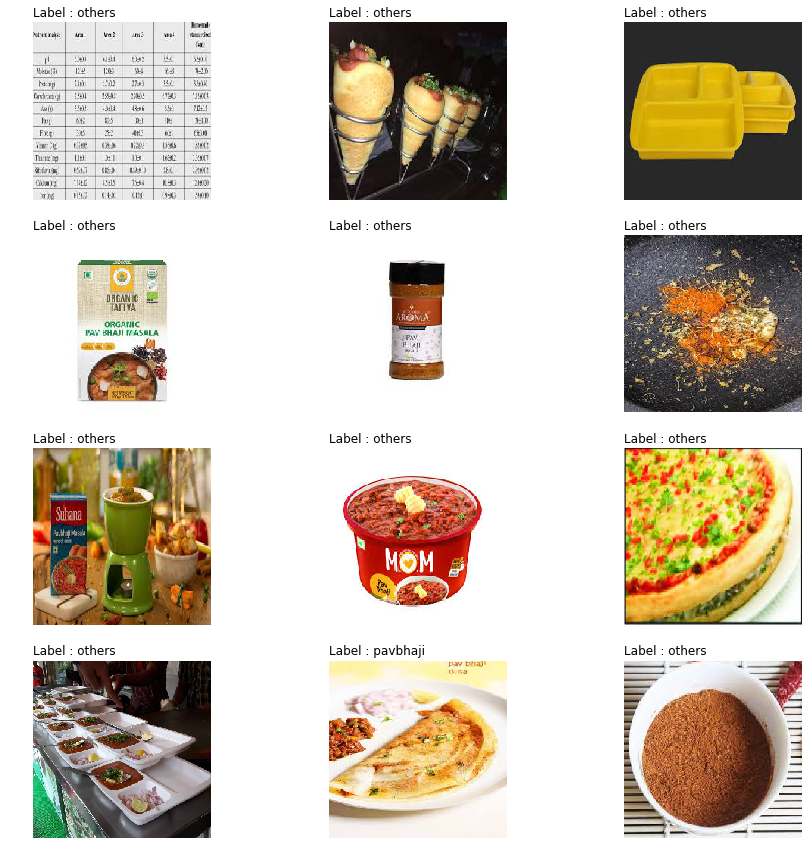

<Figure size 432x288 with 0 Axes>

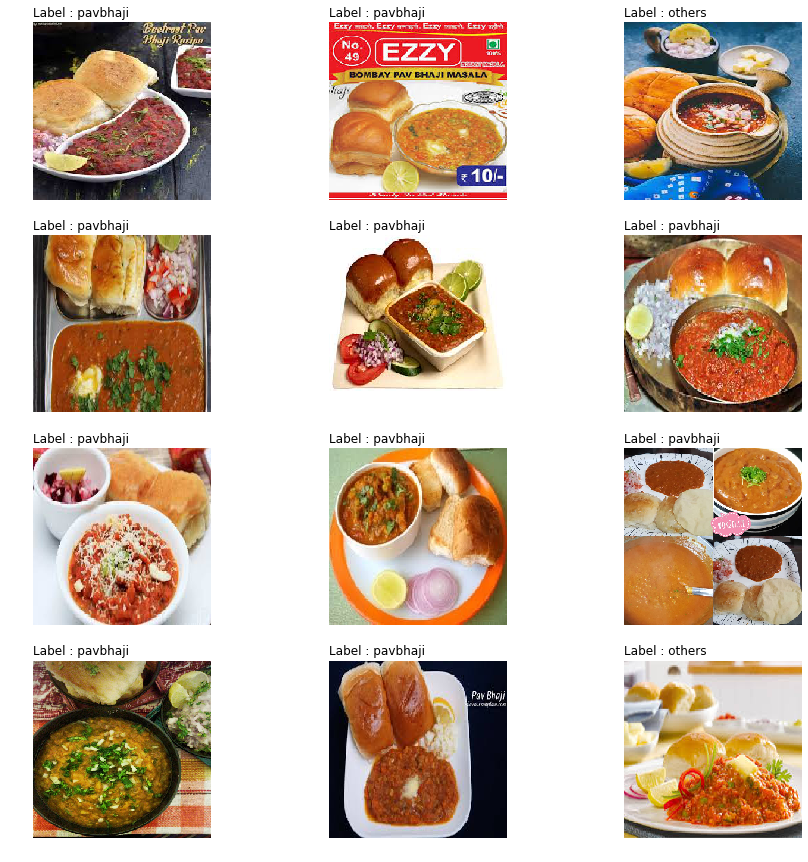

In [37]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import glob
from tensorflow.keras.applications.inception_v3 import preprocess_input


for folders in glob.glob('/home/krunal/Downloads/dataset_1/dataset/test'):
    for k in glob.glob(folders+'/*'):
        plt.figure()
        plt.subplots(1, 3, figsize=(15, 15))
        for i, file in enumerate(os.listdir(f'{k}/')):
            i += 1
            test_image = image.load_img(f'{k}/'+file, target_size=(299, 299))
            test_image = image.img_to_array(test_image)
            disp = test_image.copy()
            test_image = np.expand_dims(test_image, axis=0)
            test_image = preprocess_input(test_image)
            result = model.predict(test_image)[0]
            label = label_dict[np.argmax(result)]
            plt.subplot(4, 3, i)
            plt.axis('off')
            plt.title(f'Label : {label}', wrap=True, loc='left')
            plt.imshow(disp/255.)
            if i%12==0:
                break


43